In [8]:
# Chapter 18 Clustering
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)


X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [3]:
ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## KMeans

In [4]:
from sklearn.cluster import KMeans
X_std = preprocessing.StandardScaler().fit_transform(
    X
)
km = KMeans(2, random_state=42)
km.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [5]:
X_km = km.predict(X)
X_km

array([1, 1, 1, ..., 1, 1, 1])

Text(0,0.5,'Inertia')

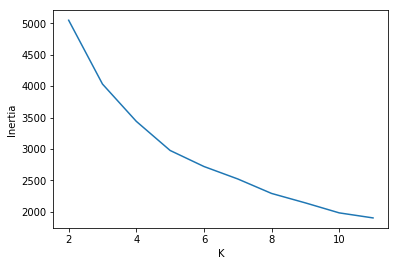

In [6]:
inertias = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(X)
    inertias.append(k2.inertia_)
fig, ax = plt.subplots(figsize=(6, 4))
pd.Series(inertias, index=sizes).plot(ax=ax)
ax.set_xlabel("K")
ax.set_ylabel("Inertia")
#fig.savefig("images/mlpr_1801.png", dpi=300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FA629C9B0>,
      dtype=object)

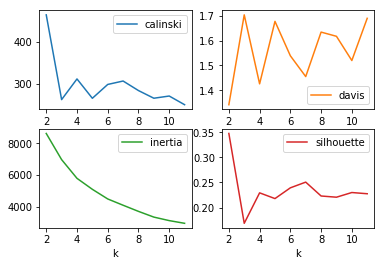

In [9]:
from sklearn import metrics
inertias = []
sils = []
chs = []
dbs = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(X_std)
    inertias.append(k2.inertia_)
    sils.append(
        metrics.silhouette_score(X, k2.labels_)
    )
    chs.append(
        metrics.calinski_harabasz_score(
            X, k2.labels_
        )
    )
    dbs.append(
        metrics.davies_bouldin_score(
            X, k2.labels_
        )
    )
fig, ax = plt.subplots(figsize=(6, 4))
(
    pd.DataFrame(
        {
            "inertia": inertias,
            "silhouette": sils,
            "calinski": chs,
            "davis": dbs,
            "k": sizes,
        }
    )
    .set_index("k")
    .plot(ax=ax, subplots=True, layout=(2, 2))
)
#fig.savefig("images/mlpr_1802.png", dpi=300)

## Heirarchy cluster

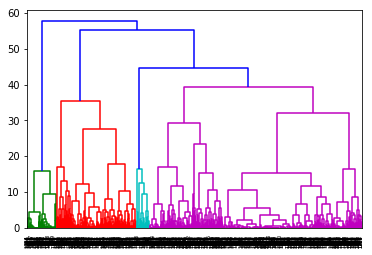

In [10]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6, 4))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_std, method="ward")
)
#fig.savefig("images/mlpr_1804.png", dpi=300)

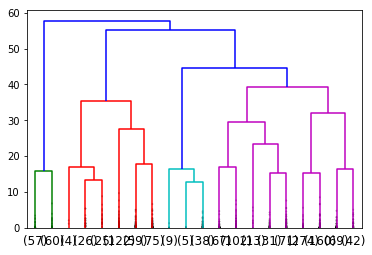

In [11]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6, 4))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_std, method="ward"),
    truncate_mode="lastp",
    p=20,
    show_contracted=True,
)
#fig.savefig("images/mlpr_1805.png", dpi=300)

In [12]:
from sklearn.cluster import (
    AgglomerativeClustering,
)
ag = AgglomerativeClustering(
    n_clusters=4,
    affinity="euclidean",
    linkage="ward",
)
ag.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [13]:
km = KMeans(n_clusters=2)
km.fit(X_std)
labels = km.predict(X_std)
(
    X.assign(cluster=labels, survived=y)
    .groupby("cluster")
    .agg(["mean", "var"])
    .T
)

cluster                 0         1
pclass     mean  0.526538 -1.423831
           var   0.266089  0.136175
age        mean -0.280031  0.920903
           var   0.653873  1.147624
sibsp      mean -0.010464 -0.107849
           var   1.163848  0.303881
parch      mean  0.387540  0.378453
           var   0.829570  0.540587
fare       mean -0.349338  0.886396
           var   0.056314  2.225435
sex_male   mean  0.678986  0.552486
           var   0.218194  0.247930
embarked_Q mean  0.123548  0.016575
           var   0.108398  0.016345
embarked_S mean  0.741288  0.585635
           var   0.191983  0.243339
survived   mean  0.299894  0.596685
           var   0.210180  0.241319

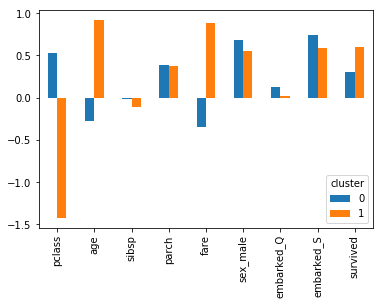

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
(
    X.assign(cluster=labels, survived=y)
    .groupby("cluster")
    .mean()
    .T.plot.bar(ax=ax)
)
# fig.savefig(
#     "images/mlpr_1806.png",
#     dpi=300,
#     bbox_inches="tight",
# )

AttributeError: module 'seaborn' has no attribute 'scatterplot'

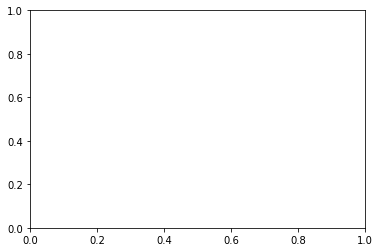

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    StandardScaler,
)

import seaborn

fig, ax = plt.subplots(figsize=(6, 4))
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(X)
)

seaborn.scatterplot(
    "PC1",
    "PC2",
    data=X.assign(
        PC1=X_pca[:, 0],
        PC2=X_pca[:, 1],
        cluster=labels,
    ),
    hue="cluster",
    alpha=0.5,
    ax=ax,
)
# fig.savefig(
#     "images/mlpr_1807.png",
#     dpi=300,
#     bbox_inches="tight",
# )

In [22]:
(
    X.assign(cluster=labels)
    .groupby("cluster")
    .age.describe()
    .T
)

cluster,0,1
count,947.000000,362.000000
mean,-0.280031,0.920903
std,0.808624,1.071272
min,-2.221251,-2.162722
25%,-0.622359,0.184938
50%,-0.172144,0.809247
75%,0.106899,1.667672
max,3.540599,4.008830


In [25]:
dt = tree.DecisionTreeClassifier()
dt.fit(X, labels)
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda col_val: col_val[1],
    reverse=True,
):
    print(col, val)

pclass 0.904764082941484
age 0.07630094141912722
sex_male 0.015637245464498725
embarked_S 0.003021149392067736
fare 0.0002765807828222184
sibsp 0.0
parch 0.0
embarked_Q 0.0


In [26]:
from io import StringIO
import pydotplus
dot_data = StringIO()
tree.export_graphviz(
    dt,
    out_file=dot_data,
    feature_names=X.columns,
    class_names=["0", "1"],
    max_depth=2,
    filled=True,
)
g = pydotplus.graph_from_dot_data(
    dot_data.getvalue()
)
#g.write_png("images/mlpr_1808.png")